In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [2]:
IMG_SIZE = 100
Channel=3
Epochs=100
Batch_size=32
no_classes=2
CATEGORIES = ["Cancer","Non-Cancer"]

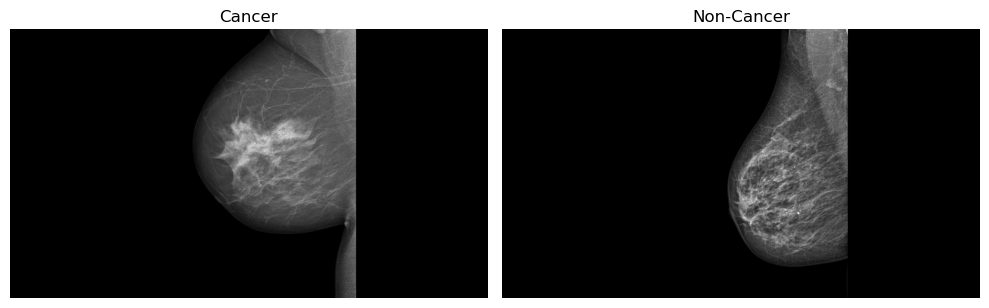

In [3]:
DATADIR = "E:/me/my Projects/dataset/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Augmented Dataset"  
CATEGORIES = ["Cancer","Non-Cancer"]
# Set up the plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()  # Flatten the axes array for easier indexing
# Loop over categories and display the first RGB image with its label
for i, category in enumerate(CATEGORIES): 
    path = os.path.join(DATADIR, category)
    img = os.listdir(path)[0]  # Get the first image from the category
    img_array = cv2.imread(os.path.join(path, img))  # Read the image in RGB
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors

    axes[i].imshow(img_array)  # Display the image
    axes[i].set_title(category)  # Add label (category) under the image
    axes[i].axis('off')  # Hide axes for better visual

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [4]:
print(img_array)
print(img_array.shape)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(1080, 1920, 3)


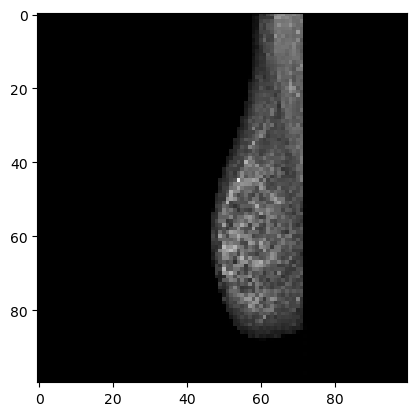

In [5]:
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [6]:
# Preparing the training data
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)  # Create path for the category
        class_num = CATEGORIES.index(category)  # Get the class label
        for img_name in tqdm(os.listdir(path), desc=f"Processing {category}"):  # Iterate over each image
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path)  # Read image
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert to RGB
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize
                training_data.append([new_array, class_num])  # Add to training data
            except Exception as e:
                print(f"Error processing image {img_name} in {category}: {e}")

create_training_data()
print(f"Total training samples: {len(training_data)}")

Processing Non-Cancer: 100%|██████████| 8060/8060 [06:07<00:00, 21.93it/s]

Total training samples: 9685


In [7]:
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

1
1
1
1
1
1
1
1
1
1


In [8]:
X = []
y = []

# Loop through training data
for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,Channel)  # Adjust shape for RGB images
X = X / 255  # Normalize pixel values
y = np.array(y)

In [10]:
print(X)
print(X.shape)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

In [11]:
base_model=keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMG_SIZE,IMG_SIZE,Channel),
    pooling=None,
    classes=no_classes,
    classifier_activation="softmax",
)

In [12]:
base_model.trainable = False

In [13]:
# Add custom layers on top of the base model
model=models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128,"relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(no_classes, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,420,714 (81.71 MB)

 Trainable params: 558,466 (2.13 MB)

 Non-trainable params: 20,862,248 (79.58 MB)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
history=model.fit(X_train, y_train, epochs=Epochs, batch_size=Batch_size,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 210s 879ms/step - accuracy: 0.7462 - loss: 0.5533 - val_accuracy: 0.9181 - val_loss: 0.2309
Epoch 2/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 162s 837ms/step - accuracy: 0.9100 - loss: 0.2524 - val_accuracy: 0.9277 - val_loss: 0.1998
Epoch 3/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 160s 823ms/step - accuracy: 0.9271 - loss: 0.2052 - val_accuracy: 0.9277 - val_loss: 0.2036
Epoch 4/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 162s 837ms/step - accuracy: 0.9376 - loss: 0.1708 - val_accuracy: 0.9374 - val_loss: 0.1692
Epoch 5/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 162s 835ms/step - accuracy: 0.9332 - loss: 0.1778 - val_accuracy: 0.9445 - val_loss: 0.1629
Epoch 6/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 160s 827ms/step - accuracy: 0.9333 - loss: 0.1727 - val_accuracy: 0.9413 - val_loss: 0.1641
Epoch 7/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 161s 830ms/step - accuracy: 0.9493 - loss: 0.1541 - val_accuracy: 0.9458 - val_loss: 0.1600
Epoch 8/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 156s 807ms/step - accuracy: 

In [18]:
test_loss, test_acc = model.evaluate(X_test,y_test)
test_acc

61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 600ms/step - accuracy: 0.9620 - loss: 0.1222


0.9628291130065918

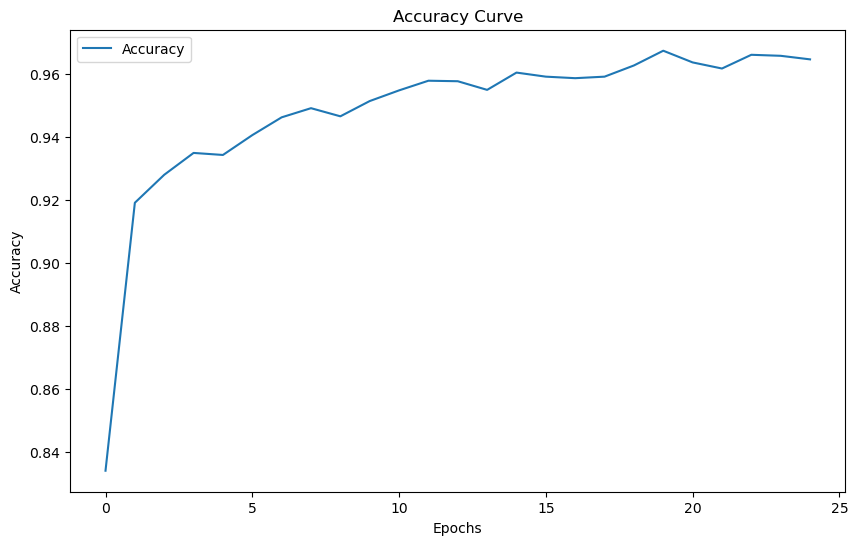

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

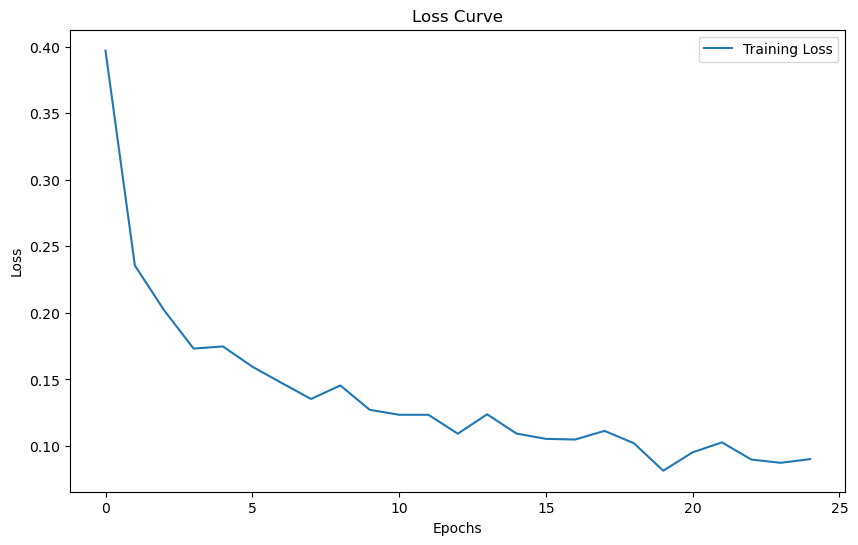

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 622ms/step


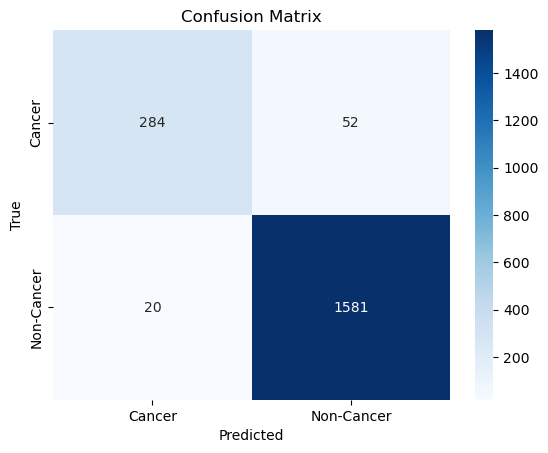

In [21]:
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # 'macro' for multiclass
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:
              precision    recall  f1-score   support

      Cancer       0.93      0.85      0.89       336
  Non-Cancer       0.97      0.99      0.98      1601

    accuracy                           0.96      1937
   macro avg       0.95      0.92      0.93      1937
weighted avg       0.96      0.96      0.96      1937

Accuracy: 0.96
Precision: 0.95
Recall: 0.92
F1-Score: 0.93


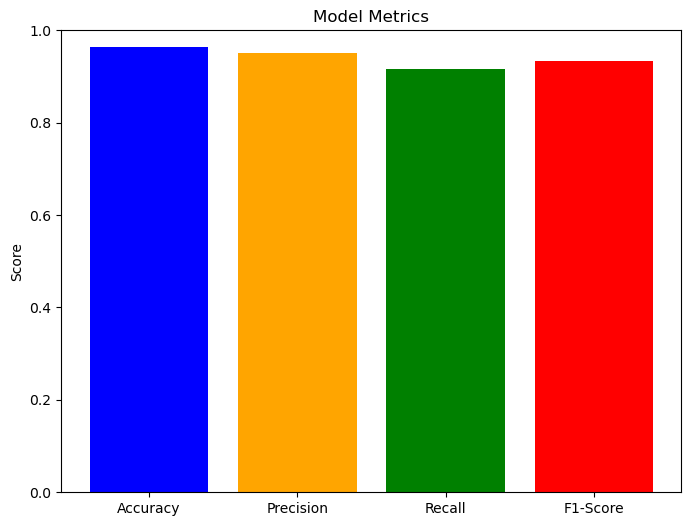

In [23]:
# Bar chart for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Model Metrics')
plt.ylabel('Score')
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step


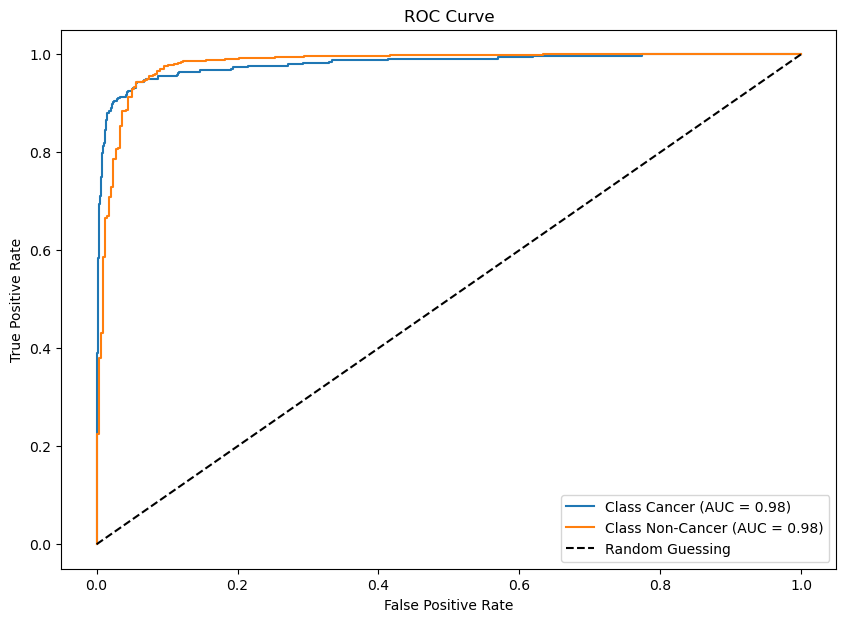

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

y_test_bin = to_categorical(y_test, num_classes=len(CATEGORIES))
y_pred_proba = model.predict(X_test)  

plt.figure(figsize=(10, 7))
for i in range(len(CATEGORIES)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {CATEGORIES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step 
Predicted category: Non-Cancer
True category: Non-Cancer


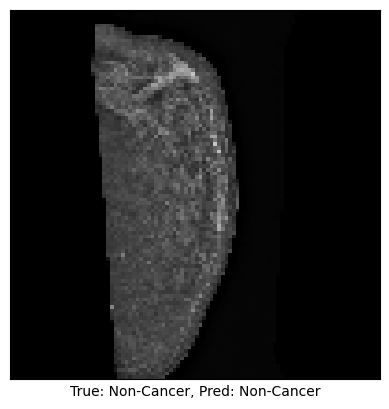

In [31]:
item =100  # The index of the image to display
predictions = model.predict(X_test)  # Get predictions for x_test
predicted_label = np.argmax(predictions[item])  # Get the predicted class label (index)
true_label = y_test[item]  # Get the true label for the item (index)

# Convert the numerical indices to category names
predicted_category = CATEGORIES[predicted_label]
true_category = CATEGORIES[true_label]

# Print the predicted and true categories
print(f"Predicted category: {predicted_category}")
print(f"True category: {true_category}")

# Display the image
plt.imshow(X_test[item])  # Display the RGB image (no colormap needed)
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.xlabel(f"True: {true_category}, Pred: {predicted_category}")  # Show category names
plt.show()

In [32]:
from tensorflow.keras.models import load_model
model_path = "C:/Users/ABA/Downloads/Xception.h5"
# Load the model
model = load_model(model_path)

In [39]:
from tensorflow.keras.preprocessing import image
from pathlib import Path

def preprocess_image(image_path):
    try:
        img = image.load_img(image_path, target_size=(IMG_SIZE,IMG_SIZE))
        # Convert the image to a numpy array and normalize it
        img_array = image.img_to_array(img) / 255
        img_array = np.expand_dims(img_array, axis=0) 
        return img_array
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None

# Path to the external image (use pathlib for better path handling)
image_path = Path("E:/me/my Projects/dataset/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (10).jpg")

# Preprocess the external image
preprocessed_image = preprocess_image(image_path)

if preprocessed_image is not None:
    print("Image preprocessed successfully!")
else:
    print("Failed to preprocess the image.")


Image preprocessed successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


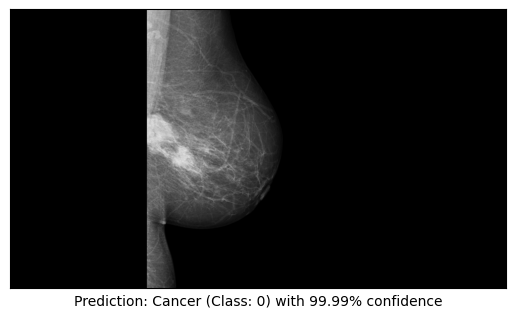

In [41]:
# Get the prediction for the image
predictions = model.predict(preprocessed_image)
predicted_label = np.argmax(predictions)
confidence = predictions[0][predicted_label] * 100

# Display the image
img = image.load_img(image_path)  # Reload the image to show it
plt.imshow(img)  # Display the RGB image
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.xlabel(f"Prediction: {CATEGORIES[predicted_label]} (Class: {predicted_label}) with {confidence:.2f}% confidence")
plt.show()

In [27]:
#model.save("Xception.h5")